# netCDF File Visualization Case Study

I was asked by a colleague to visualize data contained within this [netCDF file](https://motherlode.ucar.edu/repository/entry/show/RAMADDA/Unidata/Staff/Julien+Chastang/netcdf-explore?entryid=c7239224-d3fe-45d8-b100-43ae043824c3) ([OPeNDAP link](https://motherlode.ucar.edu/repository/opendap/41f2b38a-4e70-4135-8ff8-dbf3d1dcbfc1/entry.das)) with Python. What follows is an exploration of how I achieved that objective. Because this exercise touches upon many technologies related to Unidata, it makes for an interesting case study. We will be meandering through,

- netCDF
- WMO GRIB metadata
- Map projections
- xarray data analysis library
- cartopy visualization library

# Crack Open the File

To get our bearings let's see what there is inside our netCDF file. We will be using the [xarray library](https://github.com/pydata/xarray) to dig inside our netCDF data. xarray is similar to pandas, but for the [Common Data Model](http://www.unidata.ucar.edu/software/thredds/current/netcdf-java/CDM/). We could have just used the [netcdf4-python library](https://github.com/Unidata/netcdf4-python) but xarray has output that is more nicely formatted. Let's first import xarray and open the dataset.

In [1]:
import xarray
ds = xarray.open_dataset('https://motherlode.ucar.edu/repository/opendap/41f2b38a-4e70-4135-8ff8-dbf3d1dcbfc1/entry.das', 
                       decode_times=False)
print(ds)

<xarray.Dataset>
Dimensions:         (nav: 1, record: 1, x: 1901, y: 1801, z: 1)
Coordinates:
  * z               (z) float32 0.0
Dimensions without coordinates: nav, record, x, y
Data variables:
    u               (record, z, y, x) float32 ...
    v               (record, z, y, x) float32 ...
    p               (record, z, y, x) float32 ...
    t               (record, z, y, x) float32 ...
    td              (record, z, y, x) float32 ...
    vv              (record, z, y, x) float32 ...
    rh              (record, z, y, x) float32 ...
    msl             (record, z, y, x) float32 ...
    tad             (record, z, y, x) float32 ...
    th              (record, z, y, x) float32 ...
    the             (record, z, y, x) float32 ...
    ps              (record, z, y, x) float32 ...
    vor             (record, z, y, x) float32 ...
    mr              (record, z, y, x) float32 ...
    mrc             (record, z, y, x) float32 ...
    div             (record, z, y, x) float32 ...
    

# Dimensions, Coordinates, Data Variables

As far as the dimensions and coordinates go, the most relevant and important coordinates variables are `x` and `y`. We can see the data variables, such as, temperature (`t`), mixing ratio (`mr`), and potential temperature (`th`), are mostly on a 1901 x 1801 grid. There is also the mysterious `nav` dimension and associated data variables which we will be examining later.

Let's set a goal of visualizing **potential temperature** with the [Cartopy](http://scitools.org.uk/cartopy/) plotting package.

The first step is to get more information concerning the variables we are interested in. For example, let's look at _potential temperature_ or `th`.

In [2]:
print(ds['th'])

<xarray.DataArray 'th' (record: 1, z: 1, y: 1801, x: 1901)>
[3423701 values with dtype=float32]
Coordinates:
  * z        (z) float32 0.0
Dimensions without coordinates: record, y, x
Attributes:
    navigation_dim:  nav
    record:          valtime, reftime
    long_name:       potential temperature
    units:           kelvin
    valid_range:     [-75. 125.]
    LAPS_var:        TH
    lvl_coord:       AGL
    LAPS_units:      K


# potential temperature (`th`)

Let's grab the data array for potential temperature (`th`).

In [3]:
th = ds['th'].values[0][0]
print(th)

[[282.0028  281.97714 281.89117 ... 283.29944 281.8932  281.56363]
 [282.03864 282.0177  281.9361  ... 282.73636 281.5668  281.56363]
 [282.05988 282.05298 282.01532 ... 282.0037  281.56363 281.5663 ]
 ...
 [283.70425 283.44934 283.6949  ... 281.56363 281.56363 281.56363]
 [283.87967 283.49844 283.4708  ... 281.56363 281.56363 281.56363]
 [283.983   284.04346 284.17642 ... 281.56363 281.56363 281.56363]]


# To Visualize the Data, We have to Decrypt the Projection

In order, to visualize the data that are contained within a two-dimensional array onto a map that represents a three-dimensional globe, we need to understand the projection of the data.

We can make an educated guess these are contained in the data variables with the `nav` cooridinate variable.

Specifically,

- `grid_type`
- `grid_type_code`
- `x_dim`
- `y_dim`
- `Nx`
- `Ny`
- `La1`
- `Lo1`
- `LoV`
- `Latin1`
- `Latin2`
- `Dx`
- `Dy`

**But what are these??**

# For Grins, Let's Scrutinize the `grid_type_code`

In [4]:
print(ds['grid_type_code'])

<xarray.DataArray 'grid_type_code' (nav: 1)>
array([5], dtype=int32)
Dimensions without coordinates: nav
Attributes:
    long_name:  GRIB-1 GDS data representation type


# Google to the Rescue

A simple Google search of `GRIB-1 GDS data representation type` takes us to
[A GUIDE TO THE CODE FORM FM 92-IX Ext. GRIB Edition 1 from 1994](http://www.wmo.int/pages/prog/www/WMOCodes/Guides/GRIB/GRIB1-Contents.html "GRIB") document. Therein one can find an explanation of the variables needed to understand the map projection. Let's review these variables.

In [5]:
print(ds['grid_type_code'].values[0])

5


# What is `grid_type_code` of `5`?

Let's look at [Table 6 ](http://www.wmo.int/pages/prog/www/WMOCodes/Guides/GRIB/GRIB1-Contents.html "GRIB Projection Definitions"). A `grid_type_code` of `5` corresponds to a projection of **Polar Stereographic**.

# Next up `grid_type`

In [6]:
grid_type = ds['grid_type'].values
print('The grid type is ', grid_type[0])

The grid type is  b'secant lambert conformal      '


# Uh oh! Polar Stereographic or Lambert Conformal??

_Note that this newest piece of information relating to a Lambert Conformal projection disagrees with the  earlier projection information about a Polar Stereographic projection._ There is a **bug** in the metadata description of the projection.

# Moving on Anyway, next `Nx` and `Ny`

According to the grib documentation `Nx` and `Ny` represent the number grid points along the x and y axes. Let's grab those.

In [7]:
nx, ny = ds['Nx'].values[0], ds['Ny'].values[0]
print(nx, ny)


1901 1801


# `La1` and `Lo1` 

Next let's get `La1` and `Lo1` which are defined as the "first grid points" These are probably the latitude and longitude for one of the corners of the grid.

In [8]:
la1, lo1 = ds['La1'].values[0], ds['Lo1'].values[0]
print(la1, lo1)


10.160843 78.986084


# `Latin1` and `Latin2`

Next up are the rather mysteriously named `Latin1` and `Latin2` variables. When I first saw these identifiers, I thought they referred to a Unicode block, but in fact they relate to the secants of the projection cone. I do not know why they are called "Latin" and this name is confusing. **At any rate, we can feel comfortable that we are dealing with Lambert Conformal rather than Polar Stereographic.**

![Lambert Conformal](http://www.geo.hunter.cuny.edu/~jochen/gtech201/Lectures/Lec6concepts/Map%20coordinate%20systems/Lambert%20Conformal%20Conic_files/image002.gif "Lambert Conformal")

Credit: http://www.geo.hunter.cuny.edu/~jochen   

In [9]:
latin1, latin2 = ds['Latin1'].values[0], ds['Latin2'].values[0]
print(latin1, latin2)


30.0 60.0


# The Central Meridian for the Lambert Conformal Projection, `LoV`

If we are defining a Lambert Conformal projection, we will require the central meridian that the GRIB documentation refers to as `LoV`.

In [10]:
lov = ds['LoV'].values[0]
print(lov)


102.0


# `Dx` and `Dy`

Finally, let's look at the grid increments. In particular, we need to find the units.

In [11]:
print(ds['Dx'])
print(ds['Dy'])


<xarray.DataArray 'Dx' (nav: 1)>
array([3000.], dtype=float32)
Dimensions without coordinates: nav
Attributes:
    long_name:  x grid increment
    units:      meters
<xarray.DataArray 'Dy' (nav: 1)>
array([3000.], dtype=float32)
Dimensions without coordinates: nav
Attributes:
    long_name:  y grid increment
    units:      meters


# Units for `Dx` and `Dy`

The units for the deltas are in meters.

In [12]:
dx,dy = ds['Dx'].values[0],ds['Dy'].values[0]
print(dx,dy)

3000.0 3000.0


# Let's Review What We Have

We now have all the information we need to understand the Lambert projection:

- The secants of the Lambert Conformal projection (`Latin1`, `Latin2`)
- The central meridian of the projection (`LoV`)

Moreover, we have additional information that shows how the data grid relates to the projection:
    
- The number of grid points in x and y (`Nx`, `Ny`)
- The delta in meters between grid point (`Dx`, `Dy`)
- The first latitude and longitude of the data (`first latitude`, `first longitude`).

# We are Ready for Visualization (almost)!

Let's import **cartopy** and **matplotlib**.

In [13]:
%matplotlib inline

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define the Lambert Conformal Projection with Cartopy

In [14]:
proj = ccrs.LambertConformal(central_longitude=lov,standard_parallels=(latin1,latin2))

# Lambert Conformal Grid Extents

- To plot the data we need the `left`,`right`,`bottom`,`top` extents of the grid **expressed in Lambert Conformal
coordinates**.
- __**Key point**: The projection coordinate systems have flat topology and Euclidean distance.__

#  Calculating the Extents

Remember, we have:

- The number of grid points in x and y (`Nx`, `Ny`)
- The delta in meters between grid point (`Dx`, `Dy`)
- The first latitude and longitude of the data (`first latitude`, `first longitude`).

We have one of the corners in latitude and longitude, but we need to convert it LC coordinates and derive the other corner.

# Platte Carrée Projection

The Platte Carrée Projection is a very simple X,Y/Cartesian projection. It is used a lot in Cartopy because it allows you to express coordinates in familiar Latitude and Longitudes. **Remember**: The projection coordinate systems have flat topology and Euclidean distance.

# Platte Carrée

![Platte Carree](https://upload.wikimedia.org/wikipedia/commons/8/83/Equirectangular_projection_SW.jpg "Platte Carree")

Source: [Wikipedia Source](https://en.wikipedia.org/wiki/Equirectangular_projection)


# Create the PlatteCarre Cartopy Projection

In [15]:

pc = ccrs.PlateCarree()


# Convert Corner from Lat/Lon PlatteCarre to LC

The `transform_point` method translates coordinates from one projection coordinate system to the other.

In [16]:
left,bottom = proj.transform_point(lo1,la1,pc)
print(left,bottom)

-2851705.4600501494 -2903564.859896133


# Derive Opposite Corner

Derive the opposite corner from the number of points and the delta. **Again**, we can do this because the projection coordinate systems have flat topology and Euclidean distance.

In [17]:
right,top = left + nx*dx,bottom + ny*dy
print(right,top)

2851294.5399498506 2499435.140103867


# Plot It Up!

We now have the extents, we are ready to plot.

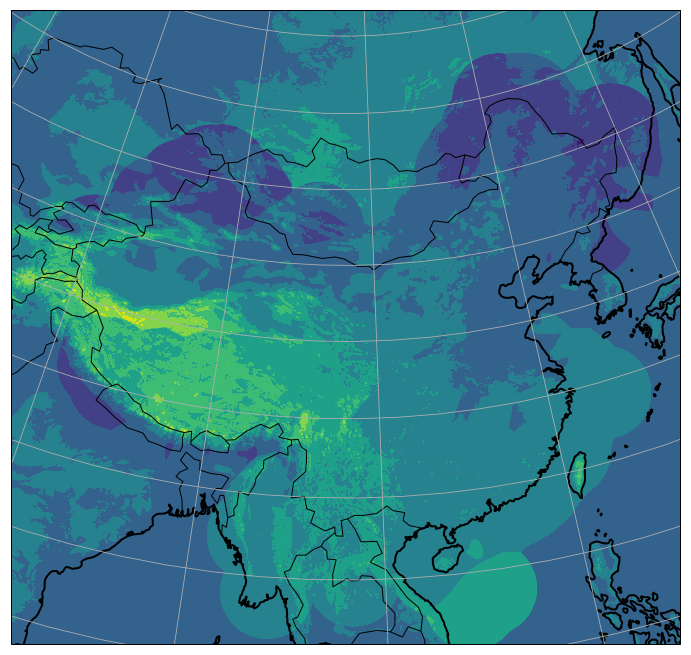

In [18]:
#Define the figure
fig = plt.figure(figsize=(12, 12))

# Define the extents and add the data
ax = plt.axes(projection=proj)
extents = (left, right, bottom, top)
ax.contourf(th, origin='lower', extent=extents, transform=proj)

# Add bells and whistles
ax.coastlines(resolution='50m', color='black', linewidth=2)
ax.add_feature(ccrs.cartopy.feature.STATES)
ax.add_feature(ccrs.cartopy.feature.BORDERS, linewidth=1, edgecolor='black')
ax.gridlines()

plt.show()

# Exercises for the Reader

- The extents are actually not perfect and snip the image. Why? Fix.
- Add a colorbar and jazz up the plot.
- Trick question: Can you label the axes with latitude and longitudes?
- Try a different projection which should be fairly easy with Cartopy.